In [1]:
# Parse arguments
import numpy as np

import argparse
parser = argparse.ArgumentParser(description='Test van der Waals grids')
parser.add_argument('--receptor_prmtop', help='Input AMBER PRMTOP file for receptor', \
  default='prmtopcrd/receptor.prmtop')
parser.add_argument('--receptor_inpcrd', help='Input coordinates for receptor', \
  default='prmtopcrd/receptor.trans.inpcrd')
parser.add_argument('--ligand_prmtop', help='Input AMBER PRMTOP file for ligand', \
  default='prmtopcrd/ligand.prmtop')
parser.add_argument('--ligand_coordinates', help='Input coordinates for ligand', \
  default='prmtopcrd/xtal_plus_dock6_scored.mol2')
parser.add_argument('--LJa', help='Input file for attractive Lennard-Jones grid', \
  default='grids/LJa.nc')
parser.add_argument('--LJr', help='Input file for repulsive Lennard-Jones grid', \
  default='grids/LJr.nc')
parser.add_argument('--ELE', help='Input file for direct electrostatic grid', \
  default='grids/direct_ele.nc')
parser.add_argument('--pbsa', help='Input file for pbsa grid', \
  default='grids/pbsa.nc')
parser.add_argument('--energy', help='File to store energies',
  default='energies.nc')
parser.add_argument('-f')
args = parser.parse_args()

# This is for the jupyter notebook
class self:
  pass

self.FNs = {\
  'prmtop_R':args.receptor_prmtop, \
  'inpcrd_R':args.receptor_inpcrd, \
  'prmtop_L':args.ligand_prmtop, \
  'crd_L':args.ligand_coordinates, \
  'LJa':args.LJa, \
  'LJr':args.LJr, \
  'ELE':args.ELE, \
  'pbsa':args.pbsa, \
  'energy':args.energy}

In [2]:
# Load prmtop and get Lennard-Jones radii and well depths
import AlGDock.IO
IO_prmtop = AlGDock.IO.prmtop()
prmtop_R = IO_prmtop.read(self.FNs['prmtop_R'], \
  varnames=['POINTERS','CHARGE','ATOM_TYPE_INDEX','NONBONDED_PARM_INDEX',\
            'LENNARD_JONES_ACOEF','LENNARD_JONES_BCOEF','MASS'])
prmtop_L = IO_prmtop.read(self.FNs['prmtop_L'], \
  varnames=['POINTERS','CHARGE','ATOM_TYPE_INDEX','NONBONDED_PARM_INDEX',\
            'LENNARD_JONES_ACOEF','LENNARD_JONES_BCOEF','MASS'])

prmtop_R['CHARGE'] = prmtop_R['CHARGE']/18.2223 # Convert to units of electric charge
prmtop_L['CHARGE'] = prmtop_L['CHARGE']/18.2223 # Convert to units of electric charge

NATOM_R = prmtop_R['POINTERS'][0]
NTYPES_R = prmtop_R['POINTERS'][1]

NATOM_L = prmtop_L['POINTERS'][0]
NTYPES_L = prmtop_L['POINTERS'][1]

def LJ_radii_and_depth(prmtop, NTYPES):
  ### Extract Lennard-Jones well depth and radii for each atom type
  LJ_radius = np.zeros(shape=(NTYPES), dtype=float)
  LJ_depth = np.zeros(shape=(NTYPES), dtype=float)
  for i in range(NTYPES):
    LJ_index = prmtop['NONBONDED_PARM_INDEX'][NTYPES*i+i]-1
    if prmtop['LENNARD_JONES_ACOEF'][LJ_index]<1.0e-6:
      LJ_radius[i] = 0
      LJ_depth[i] = 0
    else:
      factor = 2 * prmtop['LENNARD_JONES_ACOEF'][LJ_index] / prmtop['LENNARD_JONES_BCOEF'][LJ_index]
      LJ_radius[i] = pow(factor, 1.0/6.0) * 0.5 # R_min/2
      LJ_depth[i] = prmtop['LENNARD_JONES_BCOEF'][LJ_index] / 2. / factor # epsilon
  return LJ_radius, LJ_depth

LJ_radius_R, LJ_depth_R = LJ_radii_and_depth(prmtop_R, NTYPES_R)
LJ_radius_L, LJ_depth_L = LJ_radii_and_depth(prmtop_L, NTYPES_L)
#   # More useful for later calculations
#   root_LJ_depth = np.sqrt(LJ_depth)
#   LJ_diameter = LJ_radius*2

In [3]:
# Read coordinates
import AlGDock.IO
IO_crd = AlGDock.IO.crd()
self.crd_R = IO_crd.read(self.FNs['inpcrd_R'])

IO_mol2 = AlGDock.IO.dock6_mol2()
(self.crd_L,E_L) = IO_mol2.read(self.FNs['crd_L'])
# Removes poses with high scores
# self.crd_L = [self.crd_L[n] for n in range(len(self.crd_L)) if E_L['Grid Score'][n]<(E_L['Grid Score'][n]+50.)]
# Trims data for testing
self.crd_L = self.crd_L[:10]

In [4]:
# Get vdW A and B coefficients for every ligand atom
atom_type_R = [prmtop_R['ATOM_TYPE_INDEX'][n_R]-1 for n_R in range(NATOM_R)]
atom_type_L = [prmtop_L['ATOM_TYPE_INDEX'][n_L]-1 for n_L in range(NATOM_L)]

A_a = []
B_a = []
A_g = []
B_g = []
for n_L in range(NATOM_L):
  A_a_L = []
  B_a_L = []
  A_g_L = []
  B_g_L = []
  for n_R in range(NATOM_R):
    # Lorenz/Berthelot mixing (AMBER default)
    LJ_radius_ij = LJ_radius_R[atom_type_R[n_R]] + LJ_radius_L[atom_type_L[n_L]]
    LJ_depth_ij = np.sqrt(LJ_depth_R[atom_type_R[n_R]]*LJ_depth_L[atom_type_L[n_L]])
    A_a_L.append(LJ_depth_ij*LJ_radius_ij**12)
    B_a_L.append(2*LJ_depth_ij*LJ_radius_ij**6)
    # Radius from geometric mean (DOCK 6 default)
    LJ_radius_ij = np.sqrt(4.*LJ_radius_R[atom_type_R[n_R]]*LJ_radius_L[atom_type_L[n_L]])
    A_g_L.append(LJ_depth_ij*LJ_radius_ij**12)
    B_g_L.append(2*LJ_depth_ij*LJ_radius_ij**6)
  A_a.append(A_a_L)
  B_a.append(B_a_L)
  A_g.append(A_g_L)
  B_g.append(B_g_L)
A_a = np.array(A_a)
B_a = np.array(B_a)
A_g = np.array(A_g)
B_g = np.array(B_g)

In [5]:
scaling_factors = {}
scaling_factors['LJr'] = [np.sqrt(LJ_depth_L[ind])*((2*LJ_radius_L[ind])**6) for ind in atom_type_L]
scaling_factors['LJa'] = [np.sqrt(LJ_depth_L[ind])*((2*LJ_radius_L[ind])**3) for ind in atom_type_L]

In [6]:
# Calculate direct Lennard-Jones and electrostatic energies
ELE = []
LJr_LB = []
LJa_LB = []
LJr_g = []
LJa_g = []
for i_L in range(len(self.crd_L)):
  ELE_i = []
  LJr_LB_i = []
  LJa_LB_i = []
  LJr_g_i = []
  LJa_g_i = []  
  for n_L in range(NATOM_L):
    rinv  = 1/np.sqrt(np.sum(np.square(self.crd_L[i_L][n_L,:] - self.crd_R),1))
    rinv6 = np.power(rinv,6)
    rinv12 = rinv6*rinv6
    ELE_i.append(np.sum(prmtop_L['CHARGE'][n_L]*prmtop_R['CHARGE']*rinv))
    LJr_LB_i.append(np.sum(A_a[n_L]*rinv12))
    LJa_LB_i.append(-np.sum(B_a[n_L]*rinv6))
    LJr_g_i.append(np.sum(A_g[n_L]*rinv12))
    LJa_g_i.append(-np.sum(B_g[n_L]*rinv6))
  ELE.append(ELE_i)
  LJr_LB.append(LJr_LB_i)
  LJa_LB.append(LJa_LB_i)
  LJr_g.append(LJr_g_i)
  LJa_g.append(LJa_g_i)

In [7]:
# Read grids
import AlGDock.IO
IO_Grid = AlGDock.IO.Grid()
grids = {}
for key in ['LJa','LJr','ELE','pbsa']:
  grids[key] = IO_Grid.read(self.FNs[key])

In [8]:
def trilinearIterpolation(counts, spacing, vals, coordinates, scaling_factor, inv_power):
  interpolated = np.zeros(len(coordinates))
  nyz = counts[1]*counts[2]
  for atom_index in range(len(coordinates)):
    # Index within the grid
    ix = int(coordinates[atom_index][0]/spacing[0])
    iy = int(coordinates[atom_index][1]/spacing[1])
    iz = int(coordinates[atom_index][2]/spacing[2])

    i = ix*nyz + iy*counts[2] + iz

    # Corners of the box surrounding the point
    vmmm = vals[i]
    vmmp = vals[i+1]
    vmpm = vals[i+counts[2]]
    vmpp = vals[i+counts[2]+1]

    vpmm = vals[i+nyz]
    vpmp = vals[i+nyz+1]
    vppm = vals[i+nyz+counts[2]]
    vppp = vals[i+nyz+counts[2]+1]

    # Fraction within the box
    fx = (coordinates[atom_index][0] - (ix*spacing[0]))/spacing[0]
    fy = (coordinates[atom_index][1] - (iy*spacing[1]))/spacing[1]
    fz = (coordinates[atom_index][2] - (iz*spacing[2]))/spacing[2]

    # Fraction ahead
    ax = 1 - fx
    ay = 1 - fy
    az = 1 - fz

    # Trilinear interpolation for energy
    vmm = az*vmmm + fz*vmmp
    vmp = az*vmpm + fz*vmpp
    vpm = az*vpmm + fz*vpmp
    vpp = az*vppm + fz*vppp

    vm = ay*vmm + fy*vmp
    vp = ay*vpm + fy*vpp

    interpolated[atom_index] = (ax*vm + fx*vp)
  interpolated = scaling_factor*(interpolated**inv_power)
  return interpolated

In [9]:
def transformGrid(vals, inv_power):
  vals_t = np.copy(vals)

  # Transform the grid
  neg_vals = False
  # Make sure all grid values are positive
  if (vals_t>0).any():
    if (vals_t<0).any():
      raise Exception('All of the grid points do not have the same sign')
  else:
    neg_vals = True
    vals_t *= -1

  # Transform all nonzero elements
  nonzero = vals_t!=0
  vals_t[nonzero] = vals_t[nonzero]**(1./inv_power)
  return vals_t

inv_powers = np.array(range(-12,0) + range(1,13), dtype=float)
n_powers = len(inv_powers)

interpolatedE = {}
for key in ['LJr','LJa']:
  interpolatedE[key] = []
  for inv_power in inv_powers:
    transformedGrid = transformGrid(grids[key]['vals'], inv_power)
    interpolatedE[key].append([trilinearIterpolation(grids[key]['counts'], grids[key]['spacing'], \
      transformedGrid, crd, scaling_factors[key], inv_power) for crd in self.crd_L])
  
# Transformation is not available for ELE and pbsa
# because they have both positive and negative components,
# and the inverse transformation always leads to positive components
for key in ['ELE','pbsa']:
  interpolatedE[key] = [trilinearIterpolation(grids[key]['counts'], grids[key]['spacing'], \
      grids[key]['vals'], crd, prmtop_L['CHARGE'], 1) for crd in self.crd_L]

In [10]:
heavy_atom_indices = prmtop_L['MASS']>1.008
nheavy_atoms = sum(heavy_atom_indices)

In [11]:
rmsd = [np.sum(np.sqrt(np.square(self.crd_L[n][heavy_atom_indices]-self.crd_L[0][heavy_atom_indices]))/nheavy_atoms) \
   for n in range(len(self.crd_L))]

In [68]:
from netCDF4 import Dataset
energy_nc = Dataset(self.FNs['energy'],'w',format='NETCDF4')
energy_nc.createDimension('one', 1)
energy_nc.createDimension('cartesian', 3)
energy_nc.createDimension('frames', len(self.crd_L))
energy_nc.createDimension('ligand_atoms', len(self.crd_L[0]))
energy_nc.createDimension('transforms', len(inv_powers))

energy_nc.createGroup('direct')
for key in ['ELE','LJr_LB','LJa_LB','LJr_g','LJa_g']:
  energy_nc.groups['direct'].createVariable(key,'f8',('frames','ligand_atoms'))
  energy_nc.groups['direct'].variables[key][:] = locals()[key]

energy_nc.createGroup('interpolated')
for key in ['LJr','LJa']:
  energy_nc.groups['interpolated'].createVariable(key,'f8',('transforms','frames','ligand_atoms'))  
  energy_nc.groups['interpolated'].variables[key][:] = interpolatedE[key]
for key in ['ELE','pbsa']:
  energy_nc.groups['interpolated'].createVariable(key,'f8',('frames','ligand_atoms'))  
  energy_nc.groups['interpolated'].variables[key][:] = interpolatedE[key]
  
energy_nc.createVariable('rmsd','f8',('frames','one'))
energy_nc.variables['rmsd'][:] = rmsd
energy_nc.close()

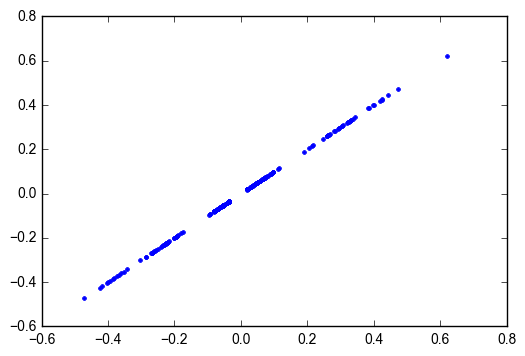

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.array(ELE).flatten(),(np.array(interpolatedE['ELE']).flatten())/332.05, '.')

In [15]:
# plt.plot(inv_powers,[np.sqrt(np.sum(np.square(np.array(LJr_a).flatten()[toKeep]-np.array(interpolatedE['LJr'][p]).flatten()[toKeep]))) for p in range(len(inv_powers))],'.')

In [16]:
np.array(ELE).shape

(10, 24)

In [17]:
np.array(interpolatedE['ELE']).shape

(10, 24)